In [21]:
import pandas as pd
from pymongo import MongoClient

In [22]:
# Set connection
client = MongoClient("mongodb://localhost:27017/")
db = client["bank"]
balances_collection = db["balances"]

# Load csv
accounts = pd.read_csv("sample/accounts.csv")
transactions = pd.read_csv("sample/transactions.csv", parse_dates=["tran_timestamp"])

In [23]:
print(transactions["tran_timestamp"].max())  # Should be 2018-12-21

2018-12-21 00:00:00+00:00


In [24]:
# Create root
balances = {}

OPEN_DATE_REFERENCE = "2017-01-01"  # Define the reference date
transactions['tran_timestamp'] = pd.to_datetime(transactions['tran_timestamp'])

# Take users data from account.csv
for _, row in accounts.iterrows():
    acc_id = row["acct_id"] # User id
    open_date = OPEN_DATE_REFERENCE if row["open_dt"] == 0 else row["open_dt"]
    initial_balance = round(float(row["initial_deposit"]), 2)

    balances[acc_id] = [{"date": pd.to_datetime(open_date),
                         "balance": initial_balance
                        }]
    
    if acc_id == 0: # Check
        print("first user must be 0 => ",str(acc_id))
        print("user 0 initial deposit must be 96646.86 => ", initial_balance)

first user must be 0 =>  0
user 0 initial deposit must be 96646.86 =>  96646.86


In [25]:
print(len(transactions))

121457


In [27]:
# Apply transactions to users' balances
transactions.sort_values(by="tran_timestamp")

for i, (_, row) in enumerate(transactions.iterrows()):
    # orig_acct = str(row["orig_acct"])
    # bene_acct = str(row["bene_acct"])
    orig_acct = row["orig_acct"]
    bene_acct = row["bene_acct"]
    amount = row["base_amt"]
    tx_type = row['tx_type']
    date = row["tran_timestamp"].strftime("%Y-%m-%d")

    if i == 0:
        print("first transaction must be from 982 to 23 => ", orig_acct, bene_acct)
    if i == 121456: # check that read till the last transaction
        print("last transaction must be from 979 to 10 => ", orig_acct, bene_acct)

    if orig_acct in balances:
        last_balance = balances[orig_acct][-1]["balance"]
        if tx_type in ['TRANSFER', 'WITHDRAWAL']:
            new_balance = last_balance - amount
        elif tx_type == 'DEPOSIT':
            new_balance = last_balance + amount

        balances[orig_acct].append({"date": date, "balance": round(new_balance, 2)})
    
    if bene_acct in balances:
        last_balance = balances[bene_acct][-1]["balance"]
        if tx_type in ['TRANSFER', 'DEPOSIT']:
            new_balance = last_balance + amount
        elif tx_type == 'WITHDRAWAL':
            new_balance = last_balance - amount

        balances[bene_acct].append({"date": date, "balance": round(new_balance, 2)})

first transaction must be from 982 to 23 =>  982 23
last transaction must be from 979 to 10 =>  979 10


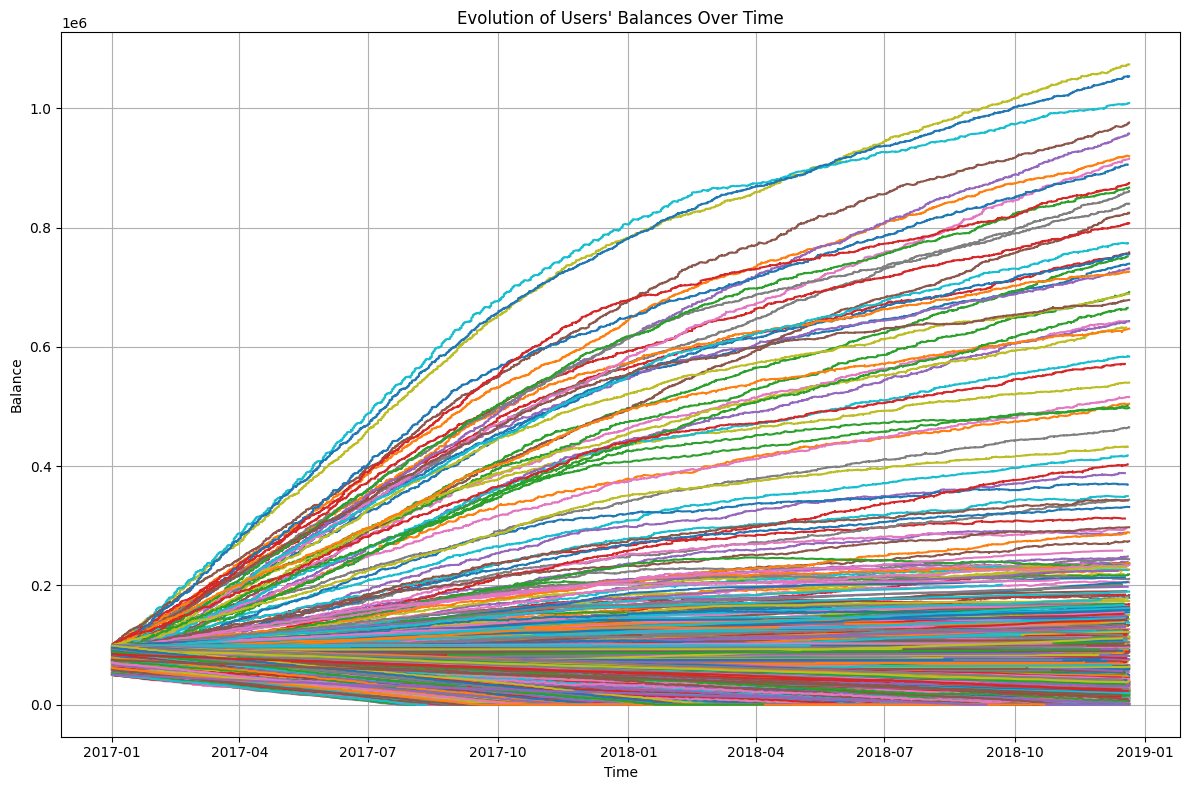

In [28]:
import matplotlib.pyplot as plt

# Plot the balance evolution for each account
plt.figure(figsize=(12, 8))
for acct_id, history in balances.items():
    dates = [entry["date"] for entry in history]
    balance_values = [entry["balance"] for entry in history]
    plt.plot(dates, balance_values, label=f'Account {acct_id}')

plt.title('Evolution of Users\' Balances Over Time')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
balances[0]

[{'date': Timestamp('2017-01-01 00:00:00'), 'balance': 96646.86},
 {'date': '2017-01-02', 'balance': 95940.59},
 {'date': '2017-01-02', 'balance': 95467.28},
 {'date': '2017-01-03', 'balance': 95055.37},
 {'date': '2017-01-09', 'balance': 94463.0},
 {'date': '2017-01-09', 'balance': 93571.26},
 {'date': '2017-01-10', 'balance': 93186.07},
 {'date': '2017-01-16', 'balance': 92431.32},
 {'date': '2017-01-16', 'balance': 91889.63},
 {'date': '2017-01-17', 'balance': 91597.51},
 {'date': '2017-01-23', 'balance': 90940.06},
 {'date': '2017-01-23', 'balance': 89982.0},
 {'date': '2017-01-24', 'balance': 89724.42},
 {'date': '2017-01-30', 'balance': 89284.3},
 {'date': '2017-01-30', 'balance': 88558.51},
 {'date': '2017-01-31', 'balance': 87855.71},
 {'date': '2017-02-06', 'balance': 87142.64},
 {'date': '2017-02-06', 'balance': 86625.91},
 {'date': '2017-02-07', 'balance': 86403.75},
 {'date': '2017-02-13', 'balance': 85603.04},
 {'date': '2017-02-13', 'balance': 84956.11},
 {'date': '2017-0

In [31]:
# Send the data to DB
for date in sorted(set(transactions["tran_timestamp"].dt.strftime("%Y-%m-%d"))):
    daily_balances = {
        "date": date,
        "balances": {str(user): {"balance": b[-1]["balance"]} for user, b in balances.items()}
    }
    balances_collection.insert_one(daily_balances)

print("All balances are now updated in the DB with transactions from 2017-01-01 to 2018-12-21")

All balances are now updated with transactions from 2017-01-01 to 2018-12-21
